# Assignment 7: Predictive Modeling of Housing Prices in Philadelphia

**NOTE: THIS ASSIGNMENT IS REQUIRED**.

**Due date: Thursday, 12/3 by the start of class**

The notebook should be submitted to your own private repository on GitHub, which can be created using the following link:

https://classroom.github.com/a/Y4xR27x5

## Part 1: Proposal for the final project

Submit a short (1/2 to 1 page) proposal that outlines and describe your plan for the final project. The proposal should discuss the following aspects of the project:

- the data set(s) you wish to use in the project,
- the questions that you want to explore
- the analysis methods and techniques that you will use 
- how the above items satisfy the requirements outlined in the [final project description](https://github.com/MUSA-550-Fall-2020/final-project)

The description of the final project can be found [here](https://github.com/MUSA-550-Fall-2020/final-project).

**Note:** if you are struggling to come up with ideas for datasets, analyses, etc, please reach out and we can discuss potential project ideas.


#### Deliverable

Upload a word document, PDF, etc to the assignment's GitHub repository with your proposal.

#### Note
For the moment, do not worry too much about how the visualizations/interactive maps will be hosted on the web. We will cover several methods for embedding your visualizations on the web in the coming weeks. These methods fall generally into three categories:

- embedding interactive altair/holoviews plots produced in Python
- creating an interactive dashboard of plots using a free-tier server to host your code

Much more on these methods in the coming weeks!


## Part 2: Modeling Philadelphia's Housing Prices and Algorithmic Fairness


### 2.1 Load data from the Office of Property Assessment

Use `carto2gpd` to load data for **single-family** properties in Philadelphia that had their **last sale during 2019**.

Sources: 
- [OpenDataPhilly](https://www.opendataphilly.org/dataset/opa-property-assessments)
- [Metadata](http://metadata.phila.gov/#home/datasetdetails/5543865f20583086178c4ee5/representationdetails/55d624fdad35c7e854cb21a4/)

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import hvplot.pandas
import esri2gpd
import carto2gpd
import seaborn as sns

np.random.seed(42)

%matplotlib inline

In [3]:
# the CARTO API url
carto_url = "https://phl.carto.com/api/v2/sql"

# The table name
table_name = "opa_properties_public"

# Only pull 2019 sales for single family residential properties
where = "sale_date >= '2019-01-01' AND sale_date < '2020-01-01'" 
where = where + " AND category_code_description = 'Single Family'"

# Run the query
salesRaw = carto2gpd.get(carto_url, table_name, where=where)

# Optional: put it a reproducible order for test/training splits later
salesRaw = salesRaw.sort_values("parcel_number")

In [4]:
salesRaw

geometry  cartodb_id assessment_date basements  \
1      POINT (-75.14854 39.93144)          23            None         0   
2      POINT (-75.14721 39.93033)          49            None         C   
0      POINT (-75.14927 39.93033)          11            None         D   
4      POINT (-75.14876 39.93011)         131            None         A   
5      POINT (-75.14886 39.93012)         133            None         C   
...                           ...         ...             ...       ...   
25440  POINT (-75.17638 39.95050)      577222            None      None   
25441  POINT (-75.17638 39.95050)      577224            None      None   
25442  POINT (-75.17638 39.95050)      577230            None      None   
25446  POINT (-75.17638 39.95050)      577368            None      None   
25447  POINT (-75.17638 39.95050)      577369            None      None   

                 beginning_point book_and_page building_code  \
1      54'7" E OF AMERICAN             3547465         R30     
2      40'4 1/2" W HOWARD ST           3517081         O50     
0      182'11" W PHILIP                3527524         O50     
4      28 FT W PHILIP                  3534307         O30     
5      56 FT W PHILIP                  3465875         O30     
...                          ...           ...           ...   
25440  112' W FROM 21ST ST             3472036         591     
25441  112' W FROM 21ST ST             3503612         5R      
25442  112' W FROM 21ST ST             3497974         5R      
25446  112' W FROM 21ST ST             3472036         5R      
25447  112' W FROM 21ST ST             3472036         5R      

      building_code_description category_code category_code_description  ...  \
1       ROW B/GAR 2 STY MASONRY             1             Single Family  ...   
2             ROW 3 STY MASONRY             1             Single Family  ...   
0             ROW 3 STY MASONRY             1             Single Family  ...   
4             ROW 2 STY MASONRY             1             Single Family  ...   
5             ROW 2 STY MASONRY             1             Single Family  ...   
...                         ...           ...                       ...  ...   
25440  RES CONDO 5+ STY MAS+OTH             1             Single Family  ...   
25441       CONDO PARKING SPACE             1             Single Family  ...   
25442       CONDO PARKING SPACE             1             Single Family  ...   
25446       CONDO PARKING SPACE             1             Single Family  ...   
25447       CONDO PARKING SPACE             1             Single Family  ...   

      type_heater unfinished     unit utility  view_type  year_built  \
1               A       None     None    None          I        1960   
2               A       None     None    None          I        1920   
0               A       None     None    None          I        1920   
4               A       None     None    None          I        1920   
5               A       None     None    None          I        1920   
...           ...        ...      ...     ...        ...         ...   
25440           A       None  00000PH       A          A        2018   
25441        None       None  000P202       A          I        2018   
25442        None       None  000P302       A          I        2018   
25446        None       None  000PPH1       A          I        2018   
25447        None       None  000PPH2       A          I        2018   

       year_built_estimate   zip_code  zoning   objectid  
1                        Y  191475336   RSA5   793879689  
2                        Y  191476128   RSA5   793879715  
0                     None  191476037   RSA5   793879747  
4                        Y  191476012   RSA5   793879753  
5                        Y  191476012   RSA5   793879755  
...                    ...        ...     ...        ...  
25440                 None  19103       RMX3   794461104  
25441                 None  19103       RMX3   794461106 

### 2.2 Load data for census tracts and neighborhoods

Load various Philadelphia-based regions we will use in our analysis.

- Census tracts can be downloaded from: http://data.phl.opendata.arcgis.com/datasets/8bc0786524a4486bb3cf0f9862ad0fbf_0.geojson
- Neighborhoods can be downloaded from:
https://raw.githubusercontent.com/azavea/geo-data/master/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.geojson


In [5]:
import requests

In [6]:
# API endpoint
API_endpoint = " http://data.phl.opendata.arcgis.com/datasets/8bc0786524a4486bb3cf0f9862ad0fbf_0.geojson"

# Get the JSON
census_tracts = requests.get(API_endpoint).json()

# Convert to a GeoDataFrame
census_tracts = gpd.GeoDataFrame.from_features(census_tracts, crs="EPSG:4326")

In [7]:
census_tracts

geometry  OBJECTID STATEFP10  \
0    POLYGON ((-75.22927 39.96054, -75.22865 39.960...         1        42   
1    POLYGON ((-75.23536 39.96852, -75.23545 39.969...         2        42   
2    POLYGON ((-75.24343 39.96230, -75.24339 39.962...         3        42   
3    POLYGON ((-75.17341 39.97779, -75.17386 39.977...         4        42   
4    POLYGON ((-75.17313 39.97776, -75.17321 39.977...         5        42   
..                                                 ...       ...       ...   
379  POLYGON ((-75.17135 39.91678, -75.17143 39.916...       380        42   
380  POLYGON ((-75.11627 40.01743, -75.11660 40.017...       381        42   
381  POLYGON ((-75.08824 40.04034, -75.08820 40.040...       382        42   
382  POLYGON ((-75.11051 39.96952, -75.10676 39.970...       383        42   
383  POLYGON ((-75.15170 39.98571, -75.15249 39.985...       384        42   

    COUNTYFP10 TRACTCE10      GEOID10 NAME10        NAMELSAD10 MTFCC10  \
0          101    009400  42101009400     94   Census Tract 94   G5020   
1          101    009500  42101009500     95   Census Tract 95   G5020   
2          101    009600  42101009600     96   Census Tract 96   G5020   
3          101    013800  42101013800    138  Census Tract 138   G5020   
4          101    013900  42101013900    139  Census Tract 139   G5020   
..         ...       ...          ...    ...               ...     ...   
379        101    037200  42101037200    372  Census Tract 372   G5020   
380        101    038300  42101038300    383  Census Tract 383   G5020   
381        101    039000  42101039000    390  Census Tract 390   G5020   
382        101    037800  42101037800    378  Census Tract 378   G5020   
383        101    037700  42101037700    377  Census Tract 377   G5020   

    FUNCSTAT10  ALAND10  AWATER10   INTPTLAT10    INTPTLON10 LOGRECNO  
0            S   366717         0  +39.9632709  -075.2322437    10429  
1            S   319070         0  +39.9658709  -075.2379140    10430  
2            S   405273         0  +39.9655396  -075.2435075    10431  
3            S   341256         0  +39.9764504  -075.1771771    10468  
4            S   562934         0  +39.9750563  -075.1711846    10469  
..         ...      ...       ...          ...           ...      ...  
379          S  1028984         0  +39.9129487  -075.1599379    10690  
380          S  3064496         0  +40.0108630  -075.1248984    10700  
381          S  2032689         0  +40.0357300  -075.0938840    10707  
382          S  3760084   1936838  +39.9805802  -075.0956845    10695  
383          S   736894         0  +39.9824381  -075.1506932    10694  

[384 rows x 15 columns]

In [8]:
# API endpoint
API_endpoint = "https://raw.githubusercontent.com/azavea/geo-data/master/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.geojson"

# Get the JSON
neighbourhoods = requests.get(API_endpoint).json()

# Convert to a GeoDataFrame
neighbourhoods = gpd.GeoDataFrame.from_features(neighbourhoods, crs="EPSG:4326")

In [9]:
neighbourhoods.head()

geometry                  name  \
0  MULTIPOLYGON (((-75.05645 40.08743, -75.05667 ...        PENNYPACK_PARK   
1  MULTIPOLYGON (((-75.22719 39.97740, -75.22984 ...             OVERBROOK   
2  MULTIPOLYGON (((-75.16208 40.02829, -75.16145 ...  GERMANTOWN_SOUTHWEST   
3  MULTIPOLYGON (((-75.19931 39.97462, -75.19869 ...         EAST_PARKSIDE   
4  MULTIPOLYGON (((-75.22722 40.03523, -75.22865 ...          GERMANY_HILL   

                listname               mapname    shape_leng    shape_area  \
0         Pennypack Park        Pennypack Park  87084.285589  6.014076e+07   
1              Overbrook             Overbrook  57004.924607  7.692499e+07   
2  Germantown, Southwest  Southwest Germantown  14880.743608  1.441867e+07   
3          East Parkside         East Parkside  10885.781535  4.231000e+06   
4           Germany Hill          Germany Hill  13041.939087  6.949968e+06   

   cartodb_id                created_at                updated_at  
0           9  2013-03-19T17:41:50.508Z  2013-03-19T17:41:50.743Z  
1         138  2013-03-19T17:41:50.508Z  2013-03-19T17:41:50.743Z  
2          59  2013-03-19T17:41:50.508Z  2013-03-19T17:41:50.743Z  
3         129  2013-03-19T17:41:50.508Z  2013-03-19T17:41:50.743Z  
4          49  2013-03-19T17:41:50.508Z  2013-03-19T17:41:50.743Z

### 2.3 Spatially join the sales data and neighborhoods/census tracts.

Perform a spatial join, such that each sale has an associated neighborhood and census tract.

**Note:** after performing the first spatial join, you will need to use the `drop()` function to remove the `index_right` column; otherwise an error will be raised on the second spatial join about duplicate columns.

In [10]:
salesRaw.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
census_tracts.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
neighbourhoods.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
joined = gpd.sjoin(salesRaw, neighbourhoods, how='left', op='intersects') 
joined

geometry  cartodb_id_left assessment_date basements  \
1      POINT (-75.14854 39.93144)               23            None         0   
2      POINT (-75.14721 39.93033)               49            None         C   
0      POINT (-75.14927 39.93033)               11            None         D   
4      POINT (-75.14876 39.93011)              131            None         A   
5      POINT (-75.14886 39.93012)              133            None         C   
...                           ...              ...             ...       ...   
25440  POINT (-75.17638 39.95050)           577222            None      None   
25441  POINT (-75.17638 39.95050)           577224            None      None   
25442  POINT (-75.17638 39.95050)           577230            None      None   
25446  POINT (-75.17638 39.95050)           577368            None      None   
25447  POINT (-75.17638 39.95050)           577369            None      None   

                 beginning_point book_and_page building_code  \
1      54'7" E OF AMERICAN             3547465         R30     
2      40'4 1/2" W HOWARD ST           3517081         O50     
0      182'11" W PHILIP                3527524         O50     
4      28 FT W PHILIP                  3534307         O30     
5      56 FT W PHILIP                  3465875         O30     
...                          ...           ...           ...   
25440  112' W FROM 21ST ST             3472036         591     
25441  112' W FROM 21ST ST             3503612         5R      
25442  112' W FROM 21ST ST             3497974         5R      
25446  112' W FROM 21ST ST             3472036         5R      
25447  112' W FROM 21ST ST             3472036         5R      

      building_code_description category_code category_code_description  ...  \
1       ROW B/GAR 2 STY MASONRY             1             Single Family  ...   
2             ROW 3 STY MASONRY             1             Single Family  ...   
0             ROW 3 STY MASONRY             1             Single Family  ...   
4             ROW 2 STY MASONRY             1             Single Family  ...   
5             ROW 2 STY MASONRY             1             Single Family  ...   
...                         ...           ...                       ...  ...   
25440  RES CONDO 5+ STY MAS+OTH             1             Single Family  ...   
25441       CONDO PARKING SPACE             1             Single Family  ...   
25442       CONDO PARKING SPACE             1             Single Family  ...   
25446       CONDO PARKING SPACE             1             Single Family  ...   
25447       CONDO PARKING SPACE             1             Single Family  ...   

        objectid index_right         name     listname      mapname  \
1      793879689        20.0    PENNSPORT    Pennsport    Pennsport   
2      793879715        20.0    PENNSPORT    Pennsport    Pennsport   
0      793879747        20.0    PENNSPORT    Pennsport    Pennsport   
4      793879753        20.0    PENNSPORT    Pennsport    Pennsport   
5      793879755        20.0    PENNSPORT    Pennsport    Pennsport   
...          ...         ...          ...          ...          ...   
25440  794461104       116.0  RITTENHOUSE  Rittenhouse  Rittenhouse   
25441  794461106       116.0  RITTENHOUSE  Rittenhouse  Rittenhouse   
25442  794461112       116.0  RITTENHOUSE  Rittenhouse  Rittenhouse   
25446  794461113       116.0  RITTENHOUSE  Rittenhouse  Rittenhouse   
25447  794461114       116.0  RITTENHOUSE  Rittenhouse  Rittenhouse   

         shape_leng    shape_area cartodb_id_right                created_at  \
1      11823.233108  6.492473e+06            155.0  2013-03-19T17:41:50.508Z   
2      11823.233108  6.492473e+06            155.0  2013-03-19T17:41:50.508Z   
0      11823.233108  6.492473e+06            155.0  2013-03-19T17:41:50.508Z   
4      11823.233108  6.492473e+06            155.0  2013-03-19T17:41:50.508Z   
5      11823.233108  6.492473e+06            155.0  2013-03-19T17:41:50.508Z   
.

In [14]:
joined = joined.drop(labels=['index_right'], axis=1)

In [15]:
sales_joined = gpd.sjoin(joined, census_tracts, how='left', op='intersects') 
sales_joined

geometry  cartodb_id_left assessment_date basements  \
1      POINT (-75.14854 39.93144)               23            None         0   
2      POINT (-75.14721 39.93033)               49            None         C   
0      POINT (-75.14927 39.93033)               11            None         D   
4      POINT (-75.14876 39.93011)              131            None         A   
5      POINT (-75.14886 39.93012)              133            None         C   
...                           ...              ...             ...       ...   
25440  POINT (-75.17638 39.95050)           577222            None      None   
25441  POINT (-75.17638 39.95050)           577224            None      None   
25442  POINT (-75.17638 39.95050)           577230            None      None   
25446  POINT (-75.17638 39.95050)           577368            None      None   
25447  POINT (-75.17638 39.95050)           577369            None      None   

                 beginning_point book_and_page building_code  \
1      54'7" E OF AMERICAN             3547465         R30     
2      40'4 1/2" W HOWARD ST           3517081         O50     
0      182'11" W PHILIP                3527524         O50     
4      28 FT W PHILIP                  3534307         O30     
5      56 FT W PHILIP                  3465875         O30     
...                          ...           ...           ...   
25440  112' W FROM 21ST ST             3472036         591     
25441  112' W FROM 21ST ST             3503612         5R      
25442  112' W FROM 21ST ST             3497974         5R      
25446  112' W FROM 21ST ST             3472036         5R      
25447  112' W FROM 21ST ST             3472036         5R      

      building_code_description category_code category_code_description  ...  \
1       ROW B/GAR 2 STY MASONRY             1             Single Family  ...   
2             ROW 3 STY MASONRY             1             Single Family  ...   
0             ROW 3 STY MASONRY             1             Single Family  ...   
4             ROW 2 STY MASONRY             1             Single Family  ...   
5             ROW 2 STY MASONRY             1             Single Family  ...   
...                         ...           ...                       ...  ...   
25440  RES CONDO 5+ STY MAS+OTH             1             Single Family  ...   
25441       CONDO PARKING SPACE             1             Single Family  ...   
25442       CONDO PARKING SPACE             1             Single Family  ...   
25446       CONDO PARKING SPACE             1             Single Family  ...   
25447       CONDO PARKING SPACE             1             Single Family  ...   

           GEOID10 NAME10          NAMELSAD10 MTFCC10  FUNCSTAT10   ALAND10  \
1      42101002702  27.02  Census Tract 27.02   G5020           S  367673.0   
2      42101002702  27.02  Census Tract 27.02   G5020           S  367673.0   
0      42101002702  27.02  Census Tract 27.02   G5020           S  367673.0   
4      42101002702  27.02  Census Tract 27.02   G5020           S  367673.0   
5      42101002702  27.02  Census Tract 27.02   G5020           S  367673.0   
...            ...    ...                 ...     ...         ...       ...   
25440  42101000803   8.03   Census Tract 8.03   G5020           S  152820.0   
25441  42101000803   8.03   Census Tract 8.03   G5020           S  152820.0   
25442  42101000803   8.03   Census Tract 8.03   G5020           S  152820.0   
25446  42101000803   8.03   Census Tract 8.03   G5020           S  152820.0   
25447  42101000803   8.03   Census Tract 8.03   G5020           S  152820.0   

       AWATER10   INTPTLAT10    INTPTLON10  LOGRECNO  
1           0.0  +39.9280114  -075.1495606     10368  
2           0.0  +39.9280114  -075.1495606     10368  
0           0.0  +39.9280114  -075.1495606     10368  
4           0.0  +39.9280114  -075.1495606     10368  
5           0.0  +39.9280114  -075.1495606     10368  
...         ...          ...           ...       ...  


### 2.4 Train a Random Forest on the sales data

You should follow the steps outlined in lecture to preprocess and train your model. 

**Extra credit: the students with the top 3 scores on the test set will receive extra credit (first place +3, second place +2, third place +1)**

**Requirements**
- Trim the sales data to those sales with prices between \\$3,000 and \\$1 million
- Set up a pipeline that includes both numerical columns and categorical columns
- Include one-hot encoded variables for the neighborhood of the sale
- Use a 70/30% training/test split
- Use GridSearchCV to perform a $k$-fold cross validation that optimize *at least 2* hyperparameters of the RandomForestRegressor
- After fitting your model and finding the optimal hyperparameters, you should evaluate the score ($R^2$) on the test set (the original 30% sample withheld)

**Notes**

- You are welcome to include additional features or perform any feature engineering that you want to try to improve the test accuracy
- You can also experiment with the prediction variable, e.g., try predicting sale price per sq ft. (or its log)

In [16]:
# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Model selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Pipelines
from sklearn.pipeline import make_pipeline

# Preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Categorical variables
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Nearest neighbours
from sklearn.neighbors import NearestNeighbors

In [17]:
# Trim very low and very high sales
valid = (sales_joined['sale_price'] > 3000) & (sales_joined['sale_price'] < 1e6)
sales = sales_joined.loc[valid]

In [18]:
# Trim zip code to only the first five digits
sales['zip_code'] = sales['zip_code'].astype(str).str.slice(0, 5)

C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [19]:
sales

geometry  cartodb_id_left assessment_date basements  \
1      POINT (-75.14854 39.93144)               23            None         0   
0      POINT (-75.14927 39.93033)               11            None         D   
4      POINT (-75.14876 39.93011)              131            None         A   
6      POINT (-75.14852 39.92954)              180            None         D   
7      POINT (-75.14871 39.92962)              184            None         A   
...                           ...              ...             ...       ...   
25744  POINT (-75.13699 39.97394)           575788            None         0   
25412  POINT (-75.17066 39.94856)           576069            None      None   
25413  POINT (-75.17066 39.94856)           576070            None      None   
25416  POINT (-75.17066 39.94856)           576202            None      None   
25435  POINT (-75.17745 39.94729)           577077            None         0   

                 beginning_point book_and_page building_code  \
1      54'7" E OF AMERICAN             3547465         R30     
0      182'11" W PHILIP                3527524         O50     
4      28 FT W PHILIP                  3534307         O30     
6      55' W 2ND ST                    3518461         O30     
7      115' W 2ND ST                   3511223         O50     
...                          ...           ...           ...   
25744  194.79' S OF OXFORD ST          3634888         550     
25412  NEC RITTENHOUSE SQ              3578021         590     
25413  NEC RITTENHOUSE SQ              3517236         590     
25416  NEC RITTENHOUSE SQ              3551693         590     
25435  143' E OF 22ND ST               3514228         570     

      building_code_description category_code category_code_description  ...  \
1       ROW B/GAR 2 STY MASONRY             1             Single Family  ...   
0             ROW 3 STY MASONRY             1             Single Family  ...   
4             ROW 2 STY MASONRY             1             Single Family  ...   
6             ROW 2 STY MASONRY             1             Single Family  ...   
7             ROW 3 STY MASONRY             1             Single Family  ...   
...                         ...           ...                       ...  ...   
25744   RES CONDO 3 STY MASONRY             1             Single Family  ...   
25412  RES CONDO 5+ STY MASONRY             1             Single Family  ...   
25413  RES CONDO 5+ STY MASONRY             1             Single Family  ...   
25416  RES CONDO 5+ STY MASONRY             1             Single Family  ...   
25435   RES CONDO 4 STY MASONRY             1             Single Family  ...   

           GEOID10 NAME10          NAMELSAD10 MTFCC10  FUNCSTAT10   ALAND10  \
1      42101002702  27.02  Census Tract 27.02   G5020           S  367673.0   
0      42101002702  27.02  Census Tract 27.02   G5020           S  367673.0   
4      42101002702  27.02  Census Tract 27.02   G5020           S  367673.0   
6      42101002702  27.02  Census Tract 27.02   G5020           S  367673.0   
7      42101002702  27.02  Census Tract 27.02   G5020           S  367673.0   
...            ...    ...                 ...     ...         ...       ...   
25744  42101014400    144    Census Tract 144   G5020           S  609439.0   
25412  42101000804   8.04   Census Tract 8.04   G5020           S  145453.0   
25413  42101000804   8.04   Census Tract 8.04   G5020           S  145453.0   
25416  42101000804   8.04   Census Tract 8.04   G5020           S  145453.0   
25435  42101001201  12.01  Census Tract 12.01   G5020           S  327555.0   

       AWATER10   INTPTLAT10    INTPTLON10  LOGRECNO  
1           0.0  +39.9280114  -075.1495606     10368  
0           0.0  +39.9280114  -075.1495606     10368  
4           0.0  +39.9280114  -075.1495606     10368  
6           0.0  +39.9280114  -075.1495606     10368  
7           0.0  +39.9280114  -075.1495606     10368  
...         ...          ...           ...       ...  


### Initial Model and R square

In [20]:
# Numerical columns
num_cols = [
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
]

# Categorical columns
cat_cols = ["exterior_condition", "zip_code"]

In [21]:
# Set up the column transformer with two transformers
# ----> Scale the numerical columns
# ----> One-hot encode the categorical columns

transformer = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

In [22]:
# Initialize the pipeline
pipe = make_pipeline(
    transformer, RandomForestRegressor(n_estimators=100, 
                                       random_state=42)
)

In [23]:
# Split the data 70/30
train_set, test_set = train_test_split(sales, 
                                       test_size=0.3, 
                                       random_state=42)

# the target labels: log of sale price
y_train = np.log(train_set["sale_price"])
y_test = np.log(test_set["sale_price"])

In [24]:
# Fit the training set
pipe.fit(train_set, y_train);

In [25]:
# Initial R square without Feature engg
pipe.score(test_set, y_test)

0.5877659554259292

### Now lets try some feature engg

In [26]:
# Now lets try some feature engg
# First lets define a function to get XY coordinates for nearest features
def get_xy_from_geometry(df):
    """
    Return a numpy array with two columns, where the 
    first holds the `x` geometry coordinate and the second 
    column holds the `y` geometry coordinate
    
    Note: this works with both Point() and Polygon() objects.
    """
    # NEW: use the centroid.x and centroid.y to support Polygon() and Point() geometries 
    x = df.geometry.centroid.x
    y = df.geometry.centroid.y
    
    return np.column_stack((x, y)) # stack as columns

In [27]:
sales = sales[sales['geometry'].notna()]

In [28]:
sales

geometry  cartodb_id_left assessment_date basements  \
1      POINT (-75.14854 39.93144)               23            None         0   
0      POINT (-75.14927 39.93033)               11            None         D   
4      POINT (-75.14876 39.93011)              131            None         A   
6      POINT (-75.14852 39.92954)              180            None         D   
7      POINT (-75.14871 39.92962)              184            None         A   
...                           ...              ...             ...       ...   
25744  POINT (-75.13699 39.97394)           575788            None         0   
25412  POINT (-75.17066 39.94856)           576069            None      None   
25413  POINT (-75.17066 39.94856)           576070            None      None   
25416  POINT (-75.17066 39.94856)           576202            None      None   
25435  POINT (-75.17745 39.94729)           577077            None         0   

                 beginning_point book_and_page building_code  \
1      54'7" E OF AMERICAN             3547465         R30     
0      182'11" W PHILIP                3527524         O50     
4      28 FT W PHILIP                  3534307         O30     
6      55' W 2ND ST                    3518461         O30     
7      115' W 2ND ST                   3511223         O50     
...                          ...           ...           ...   
25744  194.79' S OF OXFORD ST          3634888         550     
25412  NEC RITTENHOUSE SQ              3578021         590     
25413  NEC RITTENHOUSE SQ              3517236         590     
25416  NEC RITTENHOUSE SQ              3551693         590     
25435  143' E OF 22ND ST               3514228         570     

      building_code_description category_code category_code_description  ...  \
1       ROW B/GAR 2 STY MASONRY             1             Single Family  ...   
0             ROW 3 STY MASONRY             1             Single Family  ...   
4             ROW 2 STY MASONRY             1             Single Family  ...   
6             ROW 2 STY MASONRY             1             Single Family  ...   
7             ROW 3 STY MASONRY             1             Single Family  ...   
...                         ...           ...                       ...  ...   
25744   RES CONDO 3 STY MASONRY             1             Single Family  ...   
25412  RES CONDO 5+ STY MASONRY             1             Single Family  ...   
25413  RES CONDO 5+ STY MASONRY             1             Single Family  ...   
25416  RES CONDO 5+ STY MASONRY             1             Single Family  ...   
25435   RES CONDO 4 STY MASONRY             1             Single Family  ...   

           GEOID10 NAME10          NAMELSAD10 MTFCC10  FUNCSTAT10   ALAND10  \
1      42101002702  27.02  Census Tract 27.02   G5020           S  367673.0   
0      42101002702  27.02  Census Tract 27.02   G5020           S  367673.0   
4      42101002702  27.02  Census Tract 27.02   G5020           S  367673.0   
6      42101002702  27.02  Census Tract 27.02   G5020           S  367673.0   
7      42101002702  27.02  Census Tract 27.02   G5020           S  367673.0   
...            ...    ...                 ...     ...         ...       ...   
25744  42101014400    144    Census Tract 144   G5020           S  609439.0   
25412  42101000804   8.04   Census Tract 8.04   G5020           S  145453.0   
25413  42101000804   8.04   Census Tract 8.04   G5020           S  145453.0   
25416  42101000804   8.04   Census Tract 8.04   G5020           S  145453.0   
25435  42101001201  12.01  Census Tract 12.01   G5020           S  327555.0   

       AWATER10   INTPTLAT10    INTPTLON10  LOGRECNO  
1           0.0  +39.9280114  -075.1495606     10368  
0           0.0  +39.9280114  -075.1495606     10368  
4           0.0  +39.9280114  -075.1495606     10368  
6           0.0  +39.9280114  -075.1495606     10368  
7           0.0  +39.9280114  -075.1495606     10368  
...         ...          ...           ...       ...  


In [29]:
# Convert to meters and EPSG=3857
sales_3857 = sales.to_crs(epsg=3857)

# Extract x/y for sales
salesXY = get_xy_from_geometry(sales_3857)

#### Graffiti

In [31]:
# Select only those for grafitti and in 2019
where = "requested_datetime >= '01-01-2019' and requested_datetime < '01-01-2020'"
where = where + " AND service_name = 'Graffiti Removal'"

# Pull the subset we want
graffiti = carto2gpd.get(carto_url, "public_cases_fc", where=where)

# Remove rows with missing geometries
graffiti = graffiti.loc[graffiti.geometry.notnull()]

# Convert to meters in EPSG=3857
graffiti_3857 = graffiti.to_crs(epsg=3857)

# Extract x/y for grafitti calls
graffitiXY = get_xy_from_geometry(graffiti_3857)

In [32]:
# STEP 1: Initialize the algorithm
nbrs = NearestNeighbors(n_neighbors=5)

# STEP 2: Fit the algorithm on the "neighbors" dataset
nbrs.fit(graffitiXY)

# STEP 3: Get distances for sale to neighbors
grafDists, grafIndices = nbrs.kneighbors(salesXY) 

# STEP 4: Get average distance to neighbors
avgGrafDist = grafDists.mean(axis=1)

# Set zero distances to be small, but nonzero
# IMPORTANT: THIS WILL AVOID INF DISTANCES WHEN DOING THE LOG
avgGrafDist[avgGrafDist==0] = 1e-5

# STEP 5: Add the new feature
sales['logDistGraffiti'] = np.log10(avgGrafDist)

C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


#### Subways

In [33]:
import osmnx as ox

In [34]:
# Download the Philadelphia city limits
url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/arcgis/rest/services/City_Limits/FeatureServer/0"
city_limits = esri2gpd.get(url).to_crs(epsg=3857)

# Get the geometry from the city limits
city_limits_outline = city_limits.to_crs(epsg=4326).squeeze().geometry

# Get the subway stops within the city limits
subway = ox.geometries_from_polygon(city_limits_outline, tags={"station": "subway"})

# Convert to 3857 (meters)
subway = subway.to_crs(epsg=3857)

In [35]:
# STEP 1: x/y coordinates of subway stops (in EPGS=3857)
subwayXY = get_xy_from_geometry(subway.to_crs(epsg=3857))

# STEP 2: Initialize the algorithm
nbrs = NearestNeighbors(n_neighbors=1)

# STEP 3: Fit the algorithm on the "neighbors" dataset
nbrs.fit(subwayXY)

# STEP 4: Get distances for sale to neighbors
subwayDists, subwayIndices = nbrs.kneighbors(salesXY)

# STEP 5: add back to the original dataset
sales["logDistSubway"] = np.log10(subwayDists.mean(axis=1))

C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


#### Universities

In [36]:
# Get the data
url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/Universities_Colleges/FeatureServer/0"
univs = esri2gpd.get(url)

# Get the X/Y
univXY = get_xy_from_geometry(univs.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=1)
nbrs.fit(univXY)
univDists, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales['logDistUniv'] = np.log10(univDists.mean(axis=1))

C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


#### Parks

In [37]:
# Get the data
url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/PPR_Assets/FeatureServer/0"
parks = esri2gpd.get(url)

# Get the X/Y
parksXY = get_xy_from_geometry(parks.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=1)
nbrs.fit(parksXY)
parksDists, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales["logDistParks"] = np.log10(parksDists.mean(axis=1))

C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


#### Schools

In [38]:
# Get the data
url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/arcgis/rest/services/Schools/FeatureServer/0"
schools = esri2gpd.get(url)

# Get the X/Y
schoolXY = get_xy_from_geometry(schools.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=2)
nbrs.fit(schoolXY)
schoolsDists, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales["logDistSchools"] = np.log10(schoolsDists.mean(axis=1))

C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


#### City Landmarks

In [39]:
# Get the data
url = " https://services.arcgis.com/fLeGjb7u4uXqeF9q/arcgis/rest/services/CITY_LANDMARKS/FeatureServer/0"
citylandmark = esri2gpd.get(url)

# Get the X/Y
citylandmarkXY = get_xy_from_geometry(citylandmark.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=1)
nbrs.fit(citylandmarkXY)
citylandmarkDists, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales["logDistCitylandmark"] = np.log10(citylandmarkDists.mean(axis=1))

C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


#### City Hall

In [40]:
# Get the data
url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/CITY_LANDMARKS/FeatureServer/0"
cityHall = esri2gpd.get(
    url, where="NAME = 'City Hall' AND FEAT_TYPE = 'Municipal Building'"
)

# Get the X/Y
cityHallXY = get_xy_from_geometry(cityHall.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=1)
nbrs.fit(cityHallXY)
cityHallDist, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales["logDistCityHall"] = np.log10(cityHallDist.mean(axis=1))

C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


#### New Construction Permits

In [41]:
# Table name
table_name = "permits"

# Where clause
where = "permitissuedate >= '2019-01-01' AND permitissuedate < '2020-01-01'"
where = where + " AND permitdescription='NEW CONSTRUCTION PERMIT'"

# Query
permits = carto2gpd.get(carto_url, table_name, where=where)

# Remove missing
permits = permits.loc[permits.geometry.notnull()]

# Get the X/Y
permitsXY = get_xy_from_geometry(permits.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=5)
nbrs.fit(permitsXY)
permitsDist, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales["logDistPermits"] = np.log10(permitsDist.mean(axis=1))

C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


#### Aggravated Assualts

In [42]:
# Table name
table_name = "incidents_part1_part2"

# Where selection
where = "dispatch_date >= '2019-01-01' AND dispatch_date < '2020-01-01'"
where = where + " AND Text_General_Code IN ('Aggravated Assault No Firearm', 'Aggravated Assault Firearm')"

# Query
assaults = carto2gpd.get(carto_url, table_name, where=where)

# Remove missing 
assaults = assaults.loc[assaults.geometry.notnull()]
    
# Get the X/Y
assaultsXY = get_xy_from_geometry(assaults.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=5)
nbrs.fit(assaultsXY)
assaultDists, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales['logDistAssaults'] = np.log10(assaultDists.mean(axis=1))

C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


#### Abandoned Cars

In [43]:
# Table name
table_name = "public_cases_fc"

# Where selection
where = "requested_datetime >= '2019-01-01' AND requested_datetime < '2020-01-01'"
where = where + " AND service_name = 'Abandoned Vehicle'"

# Query
cars = carto2gpd.get(carto_url, table_name, where=where)

# Remove missing
cars = cars.loc[cars.geometry.notnull()]

# Get the X/Y
carsXY = get_xy_from_geometry(cars.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=5)
nbrs.fit(carsXY)
carDists, _ = nbrs.kneighbors(salesXY)

# Handle any sales that have 0 distances
carDists[carDists == 0] = 1e-5  # a small, arbitrary value

# Add the new feature
sales["logDistCars"] = np.log10(carDists.mean(axis=1))

C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


#### Sale Price

In [44]:
# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=5)
nbrs.fit(salesXY)
saleDists, saleIndex = nbrs.kneighbors(salesXY)

In [45]:
saleIndex.shape

(20131, 5)

In [46]:
saleIndex[0]

array([  0,  18,  16, 418, 388], dtype=int64)

In [47]:
sales.iloc[saleIndex[0]]

geometry  cartodb_id_left assessment_date basements  \
1    POINT (-75.14854 39.93144)               23            None         0   
26   POINT (-75.14872 39.93127)              564            None         D   
20   POINT (-75.14806 39.93112)              443            None         D   
487  POINT (-75.14890 39.93208)             9020            None      None   
570  POINT (-75.14842 39.93232)            10354            None      None   

               beginning_point book_and_page building_code  \
1    54'7" E OF AMERICAN             3547465         R30     
26   SEC SEARS ST                    3527774         O50     
20   54' N OF EARP ST                3498834         P70     
487  111.750' N SIDE WHARTON         3547268         O50     
570  SEC AMERICAN ST                 3525596         P60     

     building_code_description category_code category_code_description  ...  \
1      ROW B/GAR 2 STY MASONRY             1             Single Family  ...   
26           ROW 3 STY MASONRY             1             Single Family  ...   
20     ROW W/GAR 4 STY MASONRY             1             Single Family  ...   
487          ROW 3 STY MASONRY             1             Single Family  ...   
570  ROW W/GAR 3.5 STY MASONRY             1             Single Family  ...   

    logDistGraffiti logDistSubway logDistUniv logDistParks  logDistSchools  \
1          2.080292      3.338733    3.291227     2.026310        2.875250   
26         2.086425      3.336661    3.297734     1.950897        2.868227   
20         2.130933      3.351570    3.298893     1.753946        2.906900   
487        1.862967      3.325328    3.272971     2.298110        2.836894   
570        1.942255      3.334000    3.262200     2.278345        2.849738   

     logDistCitylandmark  logDistCityHall logDistPermits  logDistAssaults  \
1               2.043330         3.541070       2.736375         2.326162   
26              1.942164         3.542703       2.729370         2.310922   
20              1.911666         3.549332       2.736964         2.286026   
487             2.298708         3.528311       2.748293         2.384211   
570             2.278731         3.527946       2.766924         2.361914   

     logDistCars  
1       1.804171  
26      1.792526  
20      1.983496  
487     1.723575  
570     1.928676  

[5 rows x 110 columns]

In [48]:
price = sales.iloc[saleIndex[0]]
price['sale_price'].mean()

363000.0

In [49]:
price = []
for i in range(len(saleIndex)):    
    row = sales.iloc[saleIndex[i]]
    lagprice = row['sale_price'].mean()
    price.append(lagprice)

In [50]:
from pandas import DataFrame

In [51]:
price_df = DataFrame(price, columns=['lagprice'])
price_df

lagprice
0      363000.0
1      480322.0
2      381822.0
3      360322.0
4      360322.0
...         ...
20126  458260.0
20127  543280.0
20128  543280.0
20129  543280.0
20130  678650.0

[20131 rows x 1 columns]

In [60]:
sales['lagprice'] = price

C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [61]:
sales

geometry  cartodb_id_left assessment_date basements  \
1      POINT (-75.14854 39.93144)               23            None         0   
0      POINT (-75.14927 39.93033)               11            None         D   
4      POINT (-75.14876 39.93011)              131            None         A   
6      POINT (-75.14852 39.92954)              180            None         D   
7      POINT (-75.14871 39.92962)              184            None         A   
...                           ...              ...             ...       ...   
25744  POINT (-75.13699 39.97394)           575788            None         0   
25412  POINT (-75.17066 39.94856)           576069            None      None   
25413  POINT (-75.17066 39.94856)           576070            None      None   
25416  POINT (-75.17066 39.94856)           576202            None      None   
25435  POINT (-75.17745 39.94729)           577077            None         0   

                 beginning_point book_and_page building_code  \
1      54'7" E OF AMERICAN             3547465         R30     
0      182'11" W PHILIP                3527524         O50     
4      28 FT W PHILIP                  3534307         O30     
6      55' W 2ND ST                    3518461         O30     
7      115' W 2ND ST                   3511223         O50     
...                          ...           ...           ...   
25744  194.79' S OF OXFORD ST          3634888         550     
25412  NEC RITTENHOUSE SQ              3578021         590     
25413  NEC RITTENHOUSE SQ              3517236         590     
25416  NEC RITTENHOUSE SQ              3551693         590     
25435  143' E OF 22ND ST               3514228         570     

      building_code_description category_code category_code_description  ...  \
1       ROW B/GAR 2 STY MASONRY             1             Single Family  ...   
0             ROW 3 STY MASONRY             1             Single Family  ...   
4             ROW 2 STY MASONRY             1             Single Family  ...   
6             ROW 2 STY MASONRY             1             Single Family  ...   
7             ROW 3 STY MASONRY             1             Single Family  ...   
...                         ...           ...                       ...  ...   
25744   RES CONDO 3 STY MASONRY             1             Single Family  ...   
25412  RES CONDO 5+ STY MASONRY             1             Single Family  ...   
25413  RES CONDO 5+ STY MASONRY             1             Single Family  ...   
25416  RES CONDO 5+ STY MASONRY             1             Single Family  ...   
25435   RES CONDO 4 STY MASONRY             1             Single Family  ...   

      logDistSubway logDistUniv logDistParks logDistSchools  \
1          3.338733    3.291227     2.026310       2.875250   
0          3.330483    3.328747     1.992159       2.861876   
4          3.341756    3.332437     1.870258       2.895206   
6          3.347019    3.347498     2.132016       2.920236   
7          3.342907    3.346002     2.112766       2.913469   
...             ...         ...          ...            ...   
25744      2.866148    3.209514     2.206031       2.310699   
25412      2.610879    1.560642     2.281550       2.701442   
25413      2.610879    1.560642     2.281550       2.701442   
25416      2.610879    1.560642     2.281550       2.701442   
25435      2.991878    2.451936     2.420144       2.781580   

       logDistCitylandmark  logDistCityHall  logDistPermits logDistAssaults  \
1                 2.043330         3.541070        2.736375        2.326162   
0                 1.748387         3.554070        2.695040        2.175725   
4                 1.870652         3.560603        2.690248        2.039770   
6                 2.132016         3.570755        2.681175        2.008033   
7                 2.112767         3.568407        2.680723        2.023172   
...                    ...              ...             ...             ...   
25744             2.0276

#### Regression

In [62]:
# Numerical columns
num_cols = [
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "taxable_land",
    "market_value",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
    "logDistGraffiti", 
    "logDistSubway", 
    "logDistUniv",
    "logDistParks", 
    "logDistCityHall", 
    "logDistPermits", 
    "logDistAssaults", 
    "logDistCars",
    "lagprice",
    "logDistSchools",
    "logDistCitylandmark"
]

# Categorical columns
cat_cols = ["exterior_condition", "zip_code", "listname"]

In [63]:
# Set up the column transformer with two transformers
transformer = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

In [64]:
# Two steps in pipeline: preprocessor and then regressor
pipe = make_pipeline(
    transformer, RandomForestRegressor(n_estimators=20, random_state=42)
)

In [65]:
# Split the data 70/30
train_set, test_set = train_test_split(sales, test_size=0.3, random_state=42)

# the target labels
y_train = train_set["sale_price"]
y_test = test_set["sale_price"]

In [66]:
# Fit the training set
pipe.fit(train_set, y_train);

In [67]:
# What's the test score?
pipe.score(test_set, y_test)

0.8138555085626229

### 2.5 Calculate the percent error of your model predictions for each sale in the test set

Fit your best model and use it to make predictions on the test set.

**Note:** this should be the percent error in terms of **sale price** or **sale price per sq ft**. You'll need to convert if you predicted the log!

In [68]:
test_set.values[0]

array([<shapely.geometry.point.Point object at 0x000001C2040BEA48>,
       196527, None, 'D', '136\'8" E OF CORAL        ', '3544687',
       'O50  ', 'ROW 3 STY MASONRY', '1', 'Single Family', '170', None,
       None, '2015-05-14T00:00:00Z', 82.83, 0, 0, '5', 0, 15.0, None, 0,
       '0', 'A', '31', 0.0, '00', '02050', '5', '2050 E SERGEANT ST',
       None, None, 'DABBOUR MAHER 811 PARKE S', 'LANGHORNE PA',
       '811 PAQRKE ST #C         ', '19047', 120300, None, 0, 0, 0, 3, 0,
       None, 'DABBOUR MAHER            ', None, '314072500', 'E', None,
       '2019-07-31T00:00:00Z', '020N040056     ', '2019-07-24T00:00:00Z',
       199000, None, None, 'A', '1001', '71860', 'ST ', 'E', 'SERGEANT',
       None, 89335, 30965, 'F', 1242.45, 1629, 'H', None, None, None, 'I',
       '1875', 'Y', '19125', 'RSA5 ', 794075890, 'EAST_KENSINGTON',
       'East Kensington', 'East Kensington', 11570.5147893, 7672347.1013,
       150.0, '2013-03-19T17:41:50.508Z', '2013-03-19T17:41:50.743Z',
      

In [69]:
len(test_set)

6040

In [70]:
predictions = pipe.predict(test_set)
predictions

array([211092.5 ,  77122.5 , 346733.5 , ..., 438892.55, 156363.8 ,
       149550.  ])

In [71]:
error = abs(predictions - y_test)
error

8820      12092.50
21618      8122.50
24259    126733.50
21094     98054.00
2862      71122.05
           ...    
18722     20170.00
11440     12842.25
6105     113892.55
1817       1363.80
7018      60450.00
Name: sale_price, Length: 6040, dtype: float64

In [72]:
mape = 100 * ((abs(predictions - y_test.values)) / y_test.values)
mape
mape_d = {'MAPE' : mape}
mape_df = pd.DataFrame(data=mape_d)

In [78]:
mape

array([ 6.07663317, 11.77173913, 57.60613636, ..., 35.04386154,
        0.87987097, 28.78571429])

In [73]:
mape_df

MAPE
0       6.076633
1      11.771739
2      57.606136
3     124.118987
4     161.641023
...          ...
6035   16.292407
6036    8.448849
6037   35.043862
6038    0.879871
6039   28.785714

[6040 rows x 1 columns]

In [74]:
mean_mape = np.mean(mape)
mean_mape

52.671663930347805

In [76]:
test_set['MAPE']= mape

C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [77]:
test_set

geometry  cartodb_id_left assessment_date basements  \
8820   POINT (-75.12574 39.98472)           196527            None         D   
21618  POINT (-75.12553 40.04331)           454830            None         H   
24259  POINT (-75.14192 39.95202)           555888            None      None   
21094  POINT (-75.13140 40.04022)           447885            None         D   
2862   POINT (-75.15306 40.05378)            58363            None         D   
...                           ...              ...             ...       ...   
18722  POINT (-75.07658 40.03487)           390906            None         F   
11440  POINT (-75.10142 40.05016)           235460            None         D   
6105   POINT (-75.20797 40.01752)           129539            None         C   
1817   POINT (-75.20319 39.96105)            35281            None      None   
7018   POINT (-75.10904 39.98094)           155608            None         C   

                 beginning_point book_and_page building_code  \
8820   136'8" E OF CORAL               3544687         O50     
21618  390 FT N CHAMPLOST              3558386         R30     
24259  NWC FRONT + ARCH                3542428         590     
21094  136'2" N GRANGE                 3523982         O30     
2862   227' N 65TH AVE                 3470617         O30     
...                          ...           ...           ...   
18722  408'9 1/2"SE OF LARGE           3616063         R30     
11440  424'8 1/4" E OF                 3462008         R30     
6105   200' E MYK AVE                  3560312         H58     
1817   227'8 1/2" N BARING             3532727         O30     
7018   151'71/2" E THOMPSON            3554573         O31     

      building_code_description category_code category_code_description  ...  \
8820          ROW 3 STY MASONRY             1             Single Family  ...   
21618   ROW B/GAR 2 STY MASONRY             1             Single Family  ...   
24259  RES CONDO 5+ STY MASONRY             1             Single Family  ...   
21094         ROW 2 STY MASONRY             1             Single Family  ...   
2862          ROW 2 STY MASONRY             1             Single Family  ...   
...                         ...           ...                       ...  ...   
18722   ROW B/GAR 2 STY MASONRY             1             Single Family  ...   
11440   ROW B/GAR 2 STY MASONRY             1             Single Family  ...   
6105       SEMI/DET 3 STY STONE             1             Single Family  ...   
1817          ROW 2 STY MASONRY             1             Single Family  ...   
7018    ROW 2 STY MASONRY+OTHER             1             Single Family  ...   

      logDistUniv logDistParks logDistSchools logDistCitylandmark  \
8820     2.829218     2.431163       2.290987            1.955901   
21618    3.249449     2.814708       2.653880            2.169462   
24259    2.887544     2.415586       2.909051            2.308693   
21094    3.146188     2.660257       2.687453            2.400922   
2862     3.234403     2.920783       2.447915            1.864343   
...           ...          ...            ...                 ...   
18722    3.853698     2.866979       2.819203            2.541260   
11440    3.646375     2.689571       3.040259            2.625419   
6105     3.058415     2.492025       3.017046            2.373528   
1817     2.741164     2.877798       2.865145            1.638586   
7018     3.173190     2.364492       2.450282            2.210748   

       logDistCityHall  logDistPermits  logDistAssaults logDistCars  lagprice  \
8820          3.799773        2.524205         2.201849    1.801007  231000.0   
21618         4.142078        3.734387         2.191082    1.876905   86374.0   
24259         3.382483        3.218473         2.585928    2.457977  365400.0   
21094         4.122263        3.723923         2.302486    1.867482  105400.0   
2862          4.169548        3.752553         2.204118    2.043132  117200.0   
...                

### 2.6 Make a data frame with percent errors and census tract info for each sale in the test set

Create a data frame that has the property geometries, census tract data, and percent errors for all of the sales in the test set.

**Notes**

- When using the "train_test_split()" function, the index of the test data frame includes the labels from the original sales data frame
- You can use this index to slice out the test data from the original sales data frame, which should include the census tract info and geometries
- Add a new column to this data frame holding the percent error data



In [79]:
test_set.values[0]

array([<shapely.geometry.point.Point object at 0x000001C2040BEA48>,
       196527, None, 'D', '136\'8" E OF CORAL        ', '3544687',
       'O50  ', 'ROW 3 STY MASONRY', '1', 'Single Family', '170', None,
       None, '2015-05-14T00:00:00Z', 82.83, 0, 0, '5', 0, 15.0, None, 0,
       '0', 'A', '31', 0.0, '00', '02050', '5', '2050 E SERGEANT ST',
       None, None, 'DABBOUR MAHER 811 PARKE S', 'LANGHORNE PA',
       '811 PAQRKE ST #C         ', '19047', 120300, None, 0, 0, 0, 3, 0,
       None, 'DABBOUR MAHER            ', None, '314072500', 'E', None,
       '2019-07-31T00:00:00Z', '020N040056     ', '2019-07-24T00:00:00Z',
       199000, None, None, 'A', '1001', '71860', 'ST ', 'E', 'SERGEANT',
       None, 89335, 30965, 'F', 1242.45, 1629, 'H', None, None, None, 'I',
       '1875', 'Y', '19125', 'RSA5 ', 794075890, 'EAST_KENSINGTON',
       'East Kensington', 'East Kensington', 11570.5147893, 7672347.1013,
       150.0, '2013-03-19T17:41:50.508Z', '2013-03-19T17:41:50.743Z',
      

In [80]:
int(test_set.values[0,90])

42101016100

In [81]:
type(int(test_set.values[0,90]))

int

In [82]:
census = test_set.values[:,90]
census

array(['42101016100', '42101027402', '42101000100', ..., '42101020900',
       '42101009200', '42101018002'], dtype=object)

In [83]:
test_set.GEOID10

8820     42101016100
21618    42101027402
24259    42101000100
21094    42101027500
2862     42101026700
            ...     
18722    42101031200
11440    42101030600
6105     42101020900
1817     42101009200
7018     42101018002
Name: GEOID10, Length: 6040, dtype: object

In [84]:
geom = test_set.values[:,0]
geom

array([<shapely.geometry.point.Point object at 0x000001C2040BEA48>,
       <shapely.geometry.point.Point object at 0x000001C20551FB48>, ...,
      dtype=object)

In [85]:
mape[0]

6.076633165829145

In [86]:
d = {"MAPE" : mape, "GEOID10" : census, "geometry" : geom}
df = pd.DataFrame(data=d)
df

MAPE      GEOID10                              geometry
0       6.076633  42101016100          POINT (-75.125737 39.984723)
1      11.771739  42101027402          POINT (-75.125528 40.043308)
2      57.606136  42101000100  POINT (-75.14192300000001 39.952018)
3     124.118987  42101027500          POINT (-75.131399 40.040218)
4     161.641023  42101026700          POINT (-75.153063 40.053775)
...          ...          ...                                   ...
6035   16.292407  42101031200  POINT (-75.07658000000001 40.034875)
6036    8.448849  42101030600          POINT (-75.101421 40.050162)
6037   35.043862  42101020900  POINT (-75.20796900000001 40.017519)
6038    0.879871  42101009200          POINT (-75.203187 39.961047)
6039   28.785714  42101018002           POINT (-75.109042 39.98094)

[6040 rows x 3 columns]

### 2.8 Plot a map of the median percent error by census tract 

- You'll want to group your data frame of test sales by the `GEOID10` column and take the median of you percent error column
- Merge the census tract geometries back in and use geopandas to plot.

In [87]:
mape_census = df.groupby(['GEOID10']).median().reset_index()
mape_census

GEOID10       MAPE
0    42101000100   6.290156
1    42101000200   9.953865
2    42101000300  18.604478
3    42101000401  12.170069
4    42101000402  10.457971
..           ...        ...
362  42101038600   2.789953
363  42101038700   3.386765
364  42101038800  11.775081
365  42101038900  46.420963
366  42101039000  21.349776

[367 rows x 2 columns]

In [88]:
len(mape_census['GEOID10'].unique())

367

In [89]:
len(census_tracts['GEOID10'].unique())

384

In [90]:
census_trac = census_tracts.to_crs('epsg:3734')

In [91]:
census_trac.crs

<Projected CRS: EPSG:3734>
Name: NAD83 / Ohio North (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - Ohio - SPCS - N
- bounds: (-84.81, 40.1, -80.51, 42.33)
Coordinate Operation:
- name: SPCS83 Ohio North zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [92]:
meanmape_census = pd.merge(mape_census, census_trac, on = 'GEOID10')
meanmape_census

GEOID10       MAPE  \
0    42101000100   6.290156   
1    42101000200   9.953865   
2    42101000300  18.604478   
3    42101000401  12.170069   
4    42101000402  10.457971   
..           ...        ...   
362  42101038600   2.789953   
363  42101038700   3.386765   
364  42101038800  11.775081   
365  42101038900  46.420963   
366  42101039000  21.349776   

                                              geometry  OBJECTID STATEFP10  \
0    POLYGON ((4029353.496 190842.206, 4029342.902 ...       190        42   
1    POLYGON ((4023330.353 192508.020, 4023286.212 ...       191        42   
2    POLYGON ((4018842.580 192919.277, 4018594.421 ...       192        42   
3    POLYGON ((4020457.024 191165.043, 4020461.941 ...       145        42   
4    POLYGON ((4023196.021 190918.903, 4023216.320 ...       144        42   
..                                                 ...       ...       ...   
362  POLYGON ((4005006.242 233237.110, 4004915.607 ...       339        42   
363  POLYGON ((4001159.552 236968.371, 4001181.535 ...       341        42   
364  POLYGON ((4011603.085 229916.714, 4011209.848 ...       342        42   
365  POLYGON ((4016717.200 228193.238, 4016703.158 ...       343        42   
366  POLYGON ((4041485.467 224278.178, 4041490.467 ...       382        42   

    COUNTYFP10 TRACTCE10 NAME10         NAMELSAD10 MTFCC10 FUNCSTAT10  \
0          101    000100      1     Census Tract 1   G5020          S   
1          101    000200      2     Census Tract 2   G5020          S   
2          101    000300      3     Census Tract 3   G5020          S   
3          101    000401   4.01  Census Tract 4.01   G5020          S   
4          101    000402   4.02  Census Tract 4.02   G5020          S   
..         ...       ...    ...                ...     ...        ...   
362        101    038600    386   Census Tract 386   G5020          S   
363        101    038700    387   Census Tract 387   G5020          S   
364        101    038800    388   Census Tract 388   G5020          S   
365        101    038900    389   Census Tract 389   G5020          S   
366        101    039000    390   Census Tract 390   G5020          S   

     ALAND10  AWATER10   INTPTLAT10    INTPTLON10 LOGRECNO  
0     704909         0  +39.9523827  -075.1466628    10335  
1     382478         0  +39.9553999  -075.1569775    10336  
2     548342       356  +39.9568780  -075.1716655    10337  
3     214766     14981  +39.9541871  -075.1758082    10338  
4     303680         0  +39.9532973  -075.1686952    10339  
..       ...       ...          ...           ...      ...  
362  3304398     32066  +40.0582762  -075.2110913    10703  
363  2053212     22241  +40.0833122  -075.2130770    10704  
364  1383530      4751  +40.0571595  -075.1982438    10705  
365  1280551         0  +40.0543431  -075.1682764    10706  
366  2032689         0  +40.0357300  -075.0938840    10707  

[367 rows x 16 columns]

In [93]:
meanmape_census_gdf= gpd.GeoDataFrame(meanmape_census, geometry='geometry', crs="EPSG:3857")
meanmape_census_gdf

GEOID10       MAPE  \
0    42101000100   6.290156   
1    42101000200   9.953865   
2    42101000300  18.604478   
3    42101000401  12.170069   
4    42101000402  10.457971   
..           ...        ...   
362  42101038600   2.789953   
363  42101038700   3.386765   
364  42101038800  11.775081   
365  42101038900  46.420963   
366  42101039000  21.349776   

                                              geometry  OBJECTID STATEFP10  \
0    POLYGON ((4029353.496 190842.206, 4029342.902 ...       190        42   
1    POLYGON ((4023330.353 192508.020, 4023286.212 ...       191        42   
2    POLYGON ((4018842.580 192919.277, 4018594.421 ...       192        42   
3    POLYGON ((4020457.024 191165.043, 4020461.941 ...       145        42   
4    POLYGON ((4023196.021 190918.903, 4023216.320 ...       144        42   
..                                                 ...       ...       ...   
362  POLYGON ((4005006.242 233237.110, 4004915.607 ...       339        42   
363  POLYGON ((4001159.552 236968.371, 4001181.535 ...       341        42   
364  POLYGON ((4011603.085 229916.714, 4011209.848 ...       342        42   
365  POLYGON ((4016717.200 228193.238, 4016703.158 ...       343        42   
366  POLYGON ((4041485.467 224278.178, 4041490.467 ...       382        42   

    COUNTYFP10 TRACTCE10 NAME10         NAMELSAD10 MTFCC10 FUNCSTAT10  \
0          101    000100      1     Census Tract 1   G5020          S   
1          101    000200      2     Census Tract 2   G5020          S   
2          101    000300      3     Census Tract 3   G5020          S   
3          101    000401   4.01  Census Tract 4.01   G5020          S   
4          101    000402   4.02  Census Tract 4.02   G5020          S   
..         ...       ...    ...                ...     ...        ...   
362        101    038600    386   Census Tract 386   G5020          S   
363        101    038700    387   Census Tract 387   G5020          S   
364        101    038800    388   Census Tract 388   G5020          S   
365        101    038900    389   Census Tract 389   G5020          S   
366        101    039000    390   Census Tract 390   G5020          S   

     ALAND10  AWATER10   INTPTLAT10    INTPTLON10 LOGRECNO  
0     704909         0  +39.9523827  -075.1466628    10335  
1     382478         0  +39.9553999  -075.1569775    10336  
2     548342       356  +39.9568780  -075.1716655    10337  
3     214766     14981  +39.9541871  -075.1758082    10338  
4     303680         0  +39.9532973  -075.1686952    10339  
..       ...       ...          ...           ...      ...  
362  3304398     32066  +40.0582762  -075.2110913    10703  
363  2053212     22241  +40.0833122  -075.2130770    10704  
364  1383530      4751  +40.0571595  -075.1982438    10705  
365  1280551         0  +40.0543431  -075.1682764    10706  
366  2032689         0  +40.0357300  -075.0938840    10707  

[367 rows x 16 columns]

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
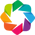

In [94]:
from matplotlib import pyplot as plt
import seaborn as sns

import hvplot.pandas
import holoviews as hv

hv.extension("bokeh")
%matplotlib inline

Text(0.5, 1.0, 'Median MAPE by census tract')

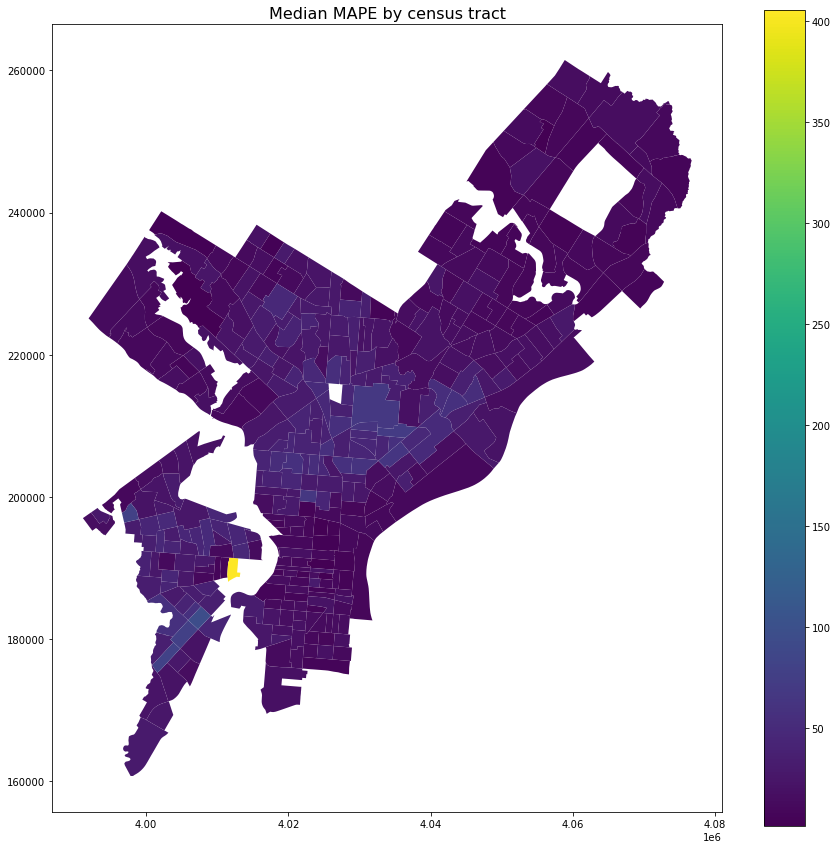

In [95]:
# create the axes
fig, ax = plt.subplots(figsize=(15, 15))

#Plot median income
meanmape_census_gdf.plot(ax=ax, column = 'MAPE', cmap = 'viridis', legend = True)
ax.set_title("Median MAPE by census tract", size = 16)

In [96]:
meanmape_census_gdf.crs

<Projected CRS: EPSG:3734>
Name: NAD83 / Ohio North (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - Ohio - SPCS - N
- bounds: (-84.81, 40.1, -80.51, 42.33)
Coordinate Operation:
- name: SPCS83 Ohio North zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [97]:
mapecensus = meanmape_census_gdf.to_crs('epsg:3857')

In [98]:
mapecensus.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [99]:
meanmape_census_gdf.hvplot(c='MAPE',
                        frame_width=600, 
                        frame_height=600,
                        geo = True,
                        crs = 3857,
                        title = 'Mean Percent Error',
                        cmap='viridis')

C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\site-packages\holoviews\operation\datashader.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Callable
C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\agarw\miniconda3\envs\musa-550-fall-2020\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return

:Polygons   [Longitude,Latitude]   (MAPE)

### 2.9 Compare the percent errors in Qualifying Census Tracts and other tracts 

[Qualifying Census Tracts](https://www.huduser.gov/portal/datasets/qct.html) are a poverty designation that HUD uses to allocate housing tax credits

- I've included a list of the census tract names that qualify in Philadelphia in 2019
- Add a new column to your dataframe of test set sales that is True/False depending on if the tract is a QCT
- Then, group by this new column and calculate the median percent error

**You should find that the algorithm's accuracy is significantly worse in these low-income, qualifying census tracts**

In [100]:
qct = ['5',
 '20',
 '22',
 '28.01',
 '30.01',
 '30.02',
 '31',
 '32',
 '33',
 '36',
 '37.01',
 '37.02',
 '39.01',
 '41.01',
 '41.02',
 '56',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '69',
 '70',
 '71.01',
 '71.02',
 '72',
 '73',
 '74',
 '77',
 '78',
 '80',
 '81.01',
 '81.02',
 '82',
 '83.01',
 '83.02',
 '84',
 '85',
 '86.01',
 '86.02',
 '87.01',
 '87.02',
 '88.01',
 '88.02',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '98.01',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '119',
 '121',
 '122.01',
 '122.03',
 '131',
 '132',
 '137',
 '138',
 '139',
 '140',
 '141',
 '144',
 '145',
 '146',
 '147',
 '148',
 '149',
 '151.01',
 '151.02',
 '152',
 '153',
 '156',
 '157',
 '161',
 '162',
 '163',
 '164',
 '165',
 '167.01',
 '167.02',
 '168',
 '169.01',
 '169.02',
 '170',
 '171',
 '172.01',
 '172.02',
 '173',
 '174',
 '175',
 '176.01',
 '176.02',
 '177.01',
 '177.02',
 '178',
 '179',
 '180.02',
 '188',
 '190',
 '191',
 '192',
 '195.01',
 '195.02',
 '197',
 '198',
 '199',
 '200',
 '201.01',
 '201.02',
 '202',
 '203',
 '204',
 '205',
 '206',
 '208',
 '239',
 '240',
 '241',
 '242',
 '243',
 '244',
 '245',
 '246',
 '247',
 '249',
 '252',
 '253',
 '265',
 '267',
 '268',
 '271',
 '274.01',
 '274.02',
 '275',
 '276',
 '277',
 '278',
 '279.01',
 '279.02',
 '280',
 '281',
 '282',
 '283',
 '284',
 '285',
 '286',
 '287',
 '288',
 '289.01',
 '289.02',
 '290',
 '291',
 '293',
 '294',
 '298',
 '299',
 '300',
 '301',
 '302',
 '305.01',
 '305.02',
 '309',
 '311.01',
 '312',
 '313',
 '314.01',
 '314.02',
 '316',
 '318',
 '319',
 '321',
 '325',
 '329',
 '330',
 '337.01',
 '345.01',
 '357.01',
 '376',
 '377',
 '380',
 '381',
 '382',
 '383',
 '389',
 '390']

In [101]:
meanmape_census_gdf['last'] = meanmape_census_gdf['NAMELSAD10'].astype(str).str.slice(13,)
meanmape_census_gdf

GEOID10       MAPE  \
0    42101000100   6.290156   
1    42101000200   9.953865   
2    42101000300  18.604478   
3    42101000401  12.170069   
4    42101000402  10.457971   
..           ...        ...   
362  42101038600   2.789953   
363  42101038700   3.386765   
364  42101038800  11.775081   
365  42101038900  46.420963   
366  42101039000  21.349776   

                                              geometry  OBJECTID STATEFP10  \
0    POLYGON ((4029353.496 190842.206, 4029342.902 ...       190        42   
1    POLYGON ((4023330.353 192508.020, 4023286.212 ...       191        42   
2    POLYGON ((4018842.580 192919.277, 4018594.421 ...       192        42   
3    POLYGON ((4020457.024 191165.043, 4020461.941 ...       145        42   
4    POLYGON ((4023196.021 190918.903, 4023216.320 ...       144        42   
..                                                 ...       ...       ...   
362  POLYGON ((4005006.242 233237.110, 4004915.607 ...       339        42   
363  POLYGON ((4001159.552 236968.371, 4001181.535 ...       341        42   
364  POLYGON ((4011603.085 229916.714, 4011209.848 ...       342        42   
365  POLYGON ((4016717.200 228193.238, 4016703.158 ...       343        42   
366  POLYGON ((4041485.467 224278.178, 4041490.467 ...       382        42   

    COUNTYFP10 TRACTCE10 NAME10         NAMELSAD10 MTFCC10 FUNCSTAT10  \
0          101    000100      1     Census Tract 1   G5020          S   
1          101    000200      2     Census Tract 2   G5020          S   
2          101    000300      3     Census Tract 3   G5020          S   
3          101    000401   4.01  Census Tract 4.01   G5020          S   
4          101    000402   4.02  Census Tract 4.02   G5020          S   
..         ...       ...    ...                ...     ...        ...   
362        101    038600    386   Census Tract 386   G5020          S   
363        101    038700    387   Census Tract 387   G5020          S   
364        101    038800    388   Census Tract 388   G5020          S   
365        101    038900    389   Census Tract 389   G5020          S   
366        101    039000    390   Census Tract 390   G5020          S   

     ALAND10  AWATER10   INTPTLAT10    INTPTLON10 LOGRECNO  last  
0     704909         0  +39.9523827  -075.1466628    10335     1  
1     382478         0  +39.9553999  -075.1569775    10336     2  
2     548342       356  +39.9568780  -075.1716655    10337     3  
3     214766     14981  +39.9541871  -075.1758082    10338  4.01  
4     303680         0  +39.9532973  -075.1686952    10339  4.02  
..       ...       ...          ...           ...      ...   ...  
362  3304398     32066  +40.0582762  -075.2110913    10703   386  
363  2053212     22241  +40.0833122  -075.2130770    10704   387  
364  1383530      4751  +40.0571595  -075.1982438    10705   388  
365  1280551         0  +40.0543431  -075.1682764    10706   389  
366  2032689         0  +40.0357300  -075.0938840    10707   390  

[367 rows x 17 columns]

In [102]:
qct = meanmape_census_gdf['last'].isin(qct)
qct

0      False
1      False
2      False
3      False
4      False
       ...  
362    False
363    False
364    False
365     True
366     True
Name: last, Length: 367, dtype: bool

In [103]:
meanmape_census_gdf['QCT'] = qct
meanmape_census_gdf

GEOID10       MAPE  \
0    42101000100   6.290156   
1    42101000200   9.953865   
2    42101000300  18.604478   
3    42101000401  12.170069   
4    42101000402  10.457971   
..           ...        ...   
362  42101038600   2.789953   
363  42101038700   3.386765   
364  42101038800  11.775081   
365  42101038900  46.420963   
366  42101039000  21.349776   

                                              geometry  OBJECTID STATEFP10  \
0    POLYGON ((4029353.496 190842.206, 4029342.902 ...       190        42   
1    POLYGON ((4023330.353 192508.020, 4023286.212 ...       191        42   
2    POLYGON ((4018842.580 192919.277, 4018594.421 ...       192        42   
3    POLYGON ((4020457.024 191165.043, 4020461.941 ...       145        42   
4    POLYGON ((4023196.021 190918.903, 4023216.320 ...       144        42   
..                                                 ...       ...       ...   
362  POLYGON ((4005006.242 233237.110, 4004915.607 ...       339        42   
363  POLYGON ((4001159.552 236968.371, 4001181.535 ...       341        42   
364  POLYGON ((4011603.085 229916.714, 4011209.848 ...       342        42   
365  POLYGON ((4016717.200 228193.238, 4016703.158 ...       343        42   
366  POLYGON ((4041485.467 224278.178, 4041490.467 ...       382        42   

    COUNTYFP10 TRACTCE10 NAME10         NAMELSAD10 MTFCC10 FUNCSTAT10  \
0          101    000100      1     Census Tract 1   G5020          S   
1          101    000200      2     Census Tract 2   G5020          S   
2          101    000300      3     Census Tract 3   G5020          S   
3          101    000401   4.01  Census Tract 4.01   G5020          S   
4          101    000402   4.02  Census Tract 4.02   G5020          S   
..         ...       ...    ...                ...     ...        ...   
362        101    038600    386   Census Tract 386   G5020          S   
363        101    038700    387   Census Tract 387   G5020          S   
364        101    038800    388   Census Tract 388   G5020          S   
365        101    038900    389   Census Tract 389   G5020          S   
366        101    039000    390   Census Tract 390   G5020          S   

     ALAND10  AWATER10   INTPTLAT10    INTPTLON10 LOGRECNO  last    QCT  
0     704909         0  +39.9523827  -075.1466628    10335     1  False  
1     382478         0  +39.9553999  -075.1569775    10336     2  False  
2     548342       356  +39.9568780  -075.1716655    10337     3  False  
3     214766     14981  +39.9541871  -075.1758082    10338  4.01  False  
4     303680         0  +39.9532973  -075.1686952    10339  4.02  False  
..       ...       ...          ...           ...      ...   ...    ...  
362  3304398     32066  +40.0582762  -075.2110913    10703   386  False  
363  2053212     22241  +40.0833122  -075.2130770    10704   387  False  
364  1383530      4751  +40.0571595  -075.1982438    10705   388  False  
365  1280551         0  +40.0543431  -075.1682764    10706   389   True  
366  2032689         0  +40.0357300  -075.0938840    10707   390   True  

[367 rows x 18 columns]

In [106]:
mape_reduce = meanmape_census_gdf.filter(['QCT', 'MAPE'])
mape_reduce

QCT       MAPE
0    False   6.290156
1    False   9.953865
2    False  18.604478
3    False  12.170069
4    False  10.457971
..     ...        ...
362  False   2.789953
363  False   3.386765
364  False  11.775081
365   True  46.420963
366   True  21.349776

[367 rows x 2 columns]

In [107]:
mape_census = mape_reduce.groupby(['QCT']).mean()
mape_census

MAPE
QCT             
False  14.012398
True   33.481205